**Classifying Malaria-infected and Uninfected Cells using CNNs (ResNet)**




Steps taken: 


1.   Download Dataset. 
2.   Split Dataset into three folders: Training, Validation and Test, with each folder containing two subfolders: Parasitized and Uninfected. This is done so that ready-to-use Keras ImageDataGenerators can be used.
3.   Set up train and validation ImageDataGenerators with Image Augmentation
4.   Define neural network. I use Keras' Functional Api since I implement residual connections. 
5.   Choose optimizer: for me Adam worked best. 
6.   Train the model.



*Python Script to split Dataset into Training, Validation and Test folders with each folder containing two subfolders: Parasitized and Uninfected. Performed on local machine. Zipped splitted dataset uploaded later to Colab and extracted.*

In [0]:
#import os 
#import random 
#import shutil
#from random import shuffle

#random.seed(3)

#categories = ['Parasitized', 'Uninfected']
#ratios = [0.70, 0.15, 0.15]

#for category in categories:
    # Get number of files
    #list_files = os.listdir('./'+category)
    #list_files = [f for f in list_files if f.endswith('.png')]
    #number_files = len(list_files)

    #shuffle(list_files)

    #for index, f in enumerate(list_files):
        #if index < ratios[0]*number_files: 
            #shutil.copy2('./'+category+'/'+f, './Splitted_images1/Training/'+category)
        #elif index < (ratios[0]+ratios[1])*number_files:
            #shutil.copy2('./'+category+'/'+f, './Splitted_images1/Validation/'+category)
        #else:
             #shutil.copy2('./'+category+'/'+f, './Splitted_images1/Test/'+category)

Start of Colab code

In [46]:
!ls

drive  sample_data  Splitted_images1.zip


In [0]:
cd drive/'My Drive'/Datasets

/content/drive/My Drive/Datasets


In [47]:
!unzip Splitted_images1.zip -d './unzipped'

Output hidden; open in https://colab.research.google.com to view.

In [48]:
%cd unzipped

/content/unzipped


In [49]:
!ls

Splitted_images1


In [50]:
%cd Splitted_images1/

/content/unzipped/Splitted_images1


In [51]:
!ls

Test  Training	Validation


In [54]:
%cd Splitted_images1/
!ls

/content/unzipped/Splitted_images1
Test  Training	Validation


Count the images:

In [55]:
for dataset_category in ['Training', 'Validation', 'Test']:
    for image_category in ['Parasitized', 'Uninfected']:
        list_files = os.listdir('./'+dataset_category+'/'+image_category)
        number_files = len(list_files)
        print(dataset_category, 'has', str(number_files), image_category, 'images.')
    print()

Training has 9646 Parasitized images.
Training has 9646 Uninfected images.

Validation has 2067 Parasitized images.
Validation has 2067 Uninfected images.

Test has 2066 Parasitized images.
Test has 2066 Uninfected images.



**Dataset Exploration**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import random

In [57]:
%cd Training

/content/unzipped/Splitted_images1/Training


Show some randomly selected images:
For most it is easy to see which ones are parasitized, but in the dataset are also images that have red dots inside and are uninfected. These images will most likely be difficult to classify correctly.  

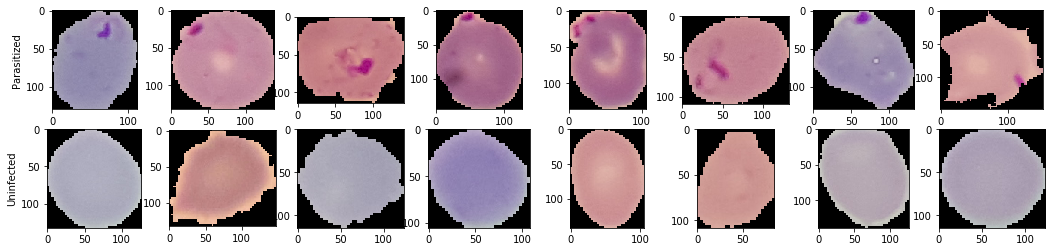

In [58]:
categories = ['Parasitized', 'Uninfected']

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(18, 4))

for i, category in enumerate(categories):
    list_files = os.listdir('./' + category)
    list_files = [f for f in list_files if f.endswith('.png')]
    number_files = len(list_files)
                            
    rands = random.sample(range(0, number_files), 8)
                            
    for j, rand in enumerate(rands):
        img = matplotlib.pyplot.imread('./' + category + '/' + list_files[rand])
        ax[:,0][i].set_ylabel(category, rotation=90)
        ax[i][j].imshow(img)

plt.show()                    

**Set up the generators:**

In [59]:
cd ..

/content/unzipped/Splitted_images1


In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_dir = './Training'
val_dir = './Validation'

Training data generator: implements also data augmentation

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=180,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

Most images are between 100 and 150 pixel wide/high. I chose to resize them to (128, 128) because 128 is divisible by 2 many times.

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=100,
    class_mode='binary')

Found 19292 images belonging to 2 classes.


In [0]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [65]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=100,
    class_mode='binary')

Found 4134 images belonging to 2 classes.


**Residual Network**

The following is the neural network used to train the model. After trying also other architectures I found that a residual network works best for this problem. I tried to follow the implementation in the original paper, but have found that some small changes improve my model (e.g. I have two FC layers at the end). The network is also not too large, which is why I omitted the bottleneck layers described in the paper.

dim_change should be true always when the dimension of the image changes. I.e. if stride is used and if number of filters change (since we need to adjust the residual connection in this case)

In [0]:
def block(start_x, channels, strides=(1,1), dim_change=False):
    x = tf.keras.layers.Conv2D(channels, (3,3), strides=strides, padding='same')(start_x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    
    if dim_change == True:
        start_x = tf.keras.layers.Conv2D(channels, (1,1), strides=strides, padding='same')(start_x)

    x = tf.keras.layers.Add()([start_x, x])
    x = tf.keras.layers.ReLU()(x)
    return x

In [0]:
inputs = tf.keras.Input(shape=(128, 128, 3))

starting_layer = tf.keras.layers.Conv2D(32, (7,7), strides=(2, 2), activation='relu', padding='same', input_shape=(128, 128, 3))(inputs)
starting_layer = tf.keras.layers.BatchNormalization(axis=-1)(starting_layer)
starting_layer = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(starting_layer)

x = block(starting_layer, 32, dim_change=False)
x = block(x, 32, dim_change=False)
x = block(x, 32, dim_change=False)
x = block(x, 32, dim_change=False)
x = block(x, 64, dim_change=True)
x = block(x, 64, strides=(2, 2), dim_change=True)

x = tf.keras.layers.AveragePooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 64, 64, 32)   128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
model.compile(loss='binary_crossentropy', 
             optimizer=Adam(lr=0.001), 
             metrics=['acc'])

In training I use two callbacks: reduceLROnPlateau and saveBestModelCallback. Reduce_lr divides the learning rate by 10 each time the model does not improve for 4 epochs. Eventhough learning rate changing is usually not necessary for Adam, it has helped in my case.  
saveBestModelCallback saves the current model if it is better than the best model until now.

In [73]:
import tensorflow as tf

bestLoss = 100.0

class saveBestModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        learning_rate = tf.keras.backend.eval(self.model.optimizer.lr)
        global bestLoss
        if(logs.get('val_loss') < bestLoss):
            print('New best loss: ', logs.get('val_loss'))
            tf.keras.models.save_model(
                model,
                './malaria_model_15_8_19.h5',
                overwrite=True,
                include_optimizer=True,
                save_format=None
            )
            bestLoss = logs.get('val_loss')
        if(learning_rate < 0.00000001):
            self.model.stop_training = True

saveBestCallback = saveBestModelCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=0.000000001)

history1 = model.fit_generator(
    train_generator, 
    steps_per_epoch=148, 
    epochs=40,
    validation_data=val_generator,
    validation_steps=41, 
    verbose=2,
    callbacks=[reduce_lr, 
               saveBestCallback])

Epoch 1/40
New best loss:  1.9905803029130145
148/148 - 91s - loss: 0.3472 - acc: 0.8476 - val_loss: 1.9906 - val_acc: 0.4744
Epoch 2/40
New best loss:  0.3958458355287226
148/148 - 80s - loss: 0.1498 - acc: 0.9506 - val_loss: 0.3958 - val_acc: 0.8439
Epoch 3/40
New best loss:  0.15047194572483621
148/148 - 81s - loss: 0.1368 - acc: 0.9551 - val_loss: 0.1505 - val_acc: 0.9522
Epoch 4/40
New best loss:  0.12566580314461778
148/148 - 81s - loss: 0.1291 - acc: 0.9565 - val_loss: 0.1257 - val_acc: 0.9571
Epoch 5/40
148/148 - 81s - loss: 0.1229 - acc: 0.9595 - val_loss: 0.1371 - val_acc: 0.9593
Epoch 6/40
New best loss:  0.12342105424258767
148/148 - 81s - loss: 0.1247 - acc: 0.9596 - val_loss: 0.1234 - val_acc: 0.9612
Epoch 7/40
148/148 - 81s - loss: 0.1231 - acc: 0.9588 - val_loss: 0.1261 - val_acc: 0.9568
Epoch 8/40
148/148 - 81s - loss: 0.1182 - acc: 0.9595 - val_loss: 0.2046 - val_acc: 0.9346
Epoch 9/40
New best loss:  0.1216480915502804
148/148 - 81s - loss: 0.1182 - acc: 0.9600 - val

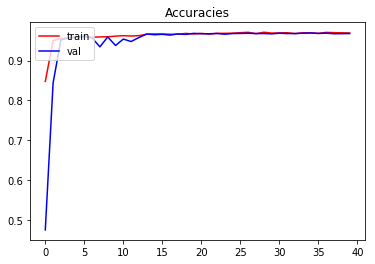

<Figure size 432x288 with 0 Axes>

In [74]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracies')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.show()

Since the model was training nicely I decided to train it a little more. I also reduced the patience parameter of the reduce_lr callback.

In [75]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.000000001)

history2 = model.fit_generator(
    train_generator, 
    steps_per_epoch=148, 
    epochs=30,
    validation_data=val_generator,
    validation_steps=41, 
    verbose=2,
    callbacks=[reduce_lr, 
               saveBestCallback])

Epoch 1/30
148/148 - 83s - loss: 0.0831 - acc: 0.9719 - val_loss: 0.0940 - val_acc: 0.9680
Epoch 2/30
148/148 - 79s - loss: 0.0833 - acc: 0.9710 - val_loss: 0.0938 - val_acc: 0.9688
Epoch 3/30
148/148 - 81s - loss: 0.0862 - acc: 0.9705 - val_loss: 0.0938 - val_acc: 0.9690
Epoch 4/30
148/148 - 80s - loss: 0.0828 - acc: 0.9702 - val_loss: 0.0939 - val_acc: 0.9685
Epoch 5/30
148/148 - 79s - loss: 0.0868 - acc: 0.9692 - val_loss: 0.0938 - val_acc: 0.9688
Epoch 6/30
148/148 - 79s - loss: 0.0820 - acc: 0.9721 - val_loss: 0.0939 - val_acc: 0.9685
Epoch 7/30
148/148 - 79s - loss: 0.0857 - acc: 0.9688 - val_loss: 0.0938 - val_acc: 0.9688
Epoch 8/30
148/148 - 80s - loss: 0.0853 - acc: 0.9687 - val_loss: 0.0939 - val_acc: 0.9690
Epoch 9/30
148/148 - 79s - loss: 0.0828 - acc: 0.9699 - val_loss: 0.0938 - val_acc: 0.9690
Epoch 10/30
148/148 - 80s - loss: 0.0902 - acc: 0.9676 - val_loss: 0.0938 - val_acc: 0.9688
Epoch 11/30
148/148 - 81s - loss: 0.0804 - acc: 0.9717 - val_loss: 0.0938 - val_acc: 0.96

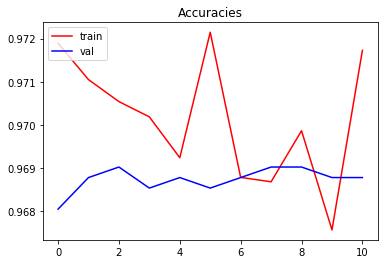

<Figure size 432x288 with 0 Axes>

In [76]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracies')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.show()

In [77]:
!ls

malaria_model_15_8_19.h5  Test	Training  Validation


Load best model:

In [0]:
import tensorflow as tf

model = tf.keras.models.load_model(
    './malaria_model_15_8_19.h5',
    custom_objects=None,
    compile=True
)

In [0]:
test_dir = './Test'

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(128, 128),
    shuffle=False,
    class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator , nb_samples, verbose=1)
loss, acc = model.evaluate_generator(test_generator, steps=nb_samples, verbose=1)

Found 4132 images belonging to 2 classes.
4132/4132 [==============================] - 34s 8ms/step - loss: 0.1057 - acc: 0.9630


In [81]:
model.predict_generator(test_generator, 5, verbose=1)

5/5 [==============================] - 0s 9ms/step


array([[0.00283394],
       [0.00771569],
       [0.00223274],
       [0.0057701 ],
       [0.03773436]], dtype=float32)

In [82]:
!ls

malaria_model_15_8_19.h5  Test	Training  Validation


In [83]:
%cd Test

/content/unzipped/Splitted_images1/Test


In [84]:
import os
import numpy as np

classes = ['Parasitized', 'Uninfected']

for category in classes:
    # Get number of files
    list_files = os.listdir('./'+category)
    list_files = [f for f in list_files if f.endswith('.png')]
    number_files = len(list_files)
    print(category, number_files)

Parasitized 2066
Uninfected 2066


In [85]:
from sklearn.metrics import confusion_matrix

y_true = np.array([0] * 2066 + [1] * 2066)
y_pred = predict > 0.5

confusion_matrix(y_true, y_pred)

array([[1964,  102],
       [  51, 2015]])

In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2066
  Uninfected       0.95      0.98      0.96      2066

    accuracy                           0.96      4132
   macro avg       0.96      0.96      0.96      4132
weighted avg       0.96      0.96      0.96      4132

